<a href="https://colab.research.google.com/github/chomsky8b/cryptoind/blob/main/Copy_of_cryptoind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm.notebook import tqdm

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
from datetime import datetime, timedelta
def scrape_and_store_data(numdays = 365):
    # Get today's date
    today = datetime.now()

    # Open CSV file in append mode
    with open('crypto_data_year.csv', 'a', newline='') as file:
        writer = csv.writer(file)

        # Iterate over 365 days
        for i in tqdm(range(numdays)):
            # Calculate the date for the URL
            date_str = (today - timedelta(days=i)).strftime('%Y-%m-%d')
            url = f"https://coincodex.com/historical-data/crypto/?date={date_str}"

            # Send a GET request to the URL
            response = requests.get(url)

            # Check if the request was successful
            if response.status_code == 200:
                # Parse the HTML content of the page
                soup = BeautifulSoup(response.content, 'html.parser')

                # Find all rows of the table containing cryptocurrency data
                rows = soup.find_all('tr', class_='coin')

                # Iterate over each row and extract relevant data
                for row in rows:
                    # Extract data from the row
                    ticker_elem = row.find(class_='ticker')
                    open_elem = row.find(class_='price')
                    volume_elem = row.find(class_='volume')
                    market_cap_elem = row.find(class_='market-cap')

                    # Check if all elements are found
                    if ticker_elem and open_elem and volume_elem and market_cap_elem:
                        ticker = ticker_elem.text.strip()
                        open_price = open_elem.text.strip().replace('$', '').replace(',', '')
                        volume = volume_elem.text.strip().replace('$', '').replace(',', '')
                        market_cap = market_cap_elem.text.strip().replace('$', '').replace(',', '')

                        # Write the data to the CSV file
                        writer.writerow([date_str, ticker, open_price, volume, market_cap])
                    else:
                        #print("Failed to extract data from a row.")
                        print("1")

                #print(f"Data for {date_str} has been scraped and stored successfully!")
            else:
                print(f"Failed to retrieve data for {date_str} from the website.")

In [ ]:
scrape_and_store_data(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
df = pd.read_csv("crypto_data_year.csv", parse_dates = [0], header=None)

FileNotFoundError: [Errno 2] No such file or directory: 'crypto_data_year.csv'

In [ ]:
df.columns = ["Date","Currency", "Price", "Volume", "MarketCap"]


In [ ]:
def convert_currency(x):
    # Remove any non-standard white-space and possible 'M' (millions) if present
    x = x.replace('\u202f', '').replace(',', '')
    try:
      if x.endswith('B'):
        return float(x.replace('B', '')) * 1e9
      elif x.endswith('T'):
        return float(x.replace('T', '')) * 1e12
      elif x.endswith('M'):  # Assuming you might have 'M' for millions as well
        return float(x.replace('M', '')) * 1e6
      else:
        return float(x)
    except:
      return np.nan

# Apply the conversion
df['Volume'] = df['Volume'].apply(convert_currency)
df['MarketCap'] = df['MarketCap'].apply(convert_currency)
df['Price'] = df['Price'].apply(convert_currency)



In [ ]:
# Define the tickers to remove
tickers_to_remove = ['USDT', 'USDC']

df = df[~df['Currency'].isin(tickers_to_remove)]
df.sort_values(by = "Date", inplace=True)

<ipython-input-101-9357666ee3b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by = "Date", inplace=True)


In [ ]:
df = df.drop_duplicates(subset=['Date', 'Currency'], keep='first')

In [ ]:
indict = {}
weightdict = []
for i, j in df.groupby('Date'):
  j = j.nlargest(20,"Volume").reset_index(drop=True)
  w = np.sqrt(j['MarketCap'])
  weightdf = pd.DataFrame(w/j["Price"]/1000)
  weightdf["Date"] = i
  weightdf["Currency"] = j["Currency"]
  weightdf["TotalCap"] = w/1000
  weightdf.columns = ["Weight", "Date", "Currency", "TotalCap"]
  weightdict.append(weightdf)
  indict[i] = np.sum(w)

In [ ]:
indser = pd.Series(indict)
indser.name = "Index"
weightdf = pd.concat(weightdict, ignore_index=True)

<Axes: >

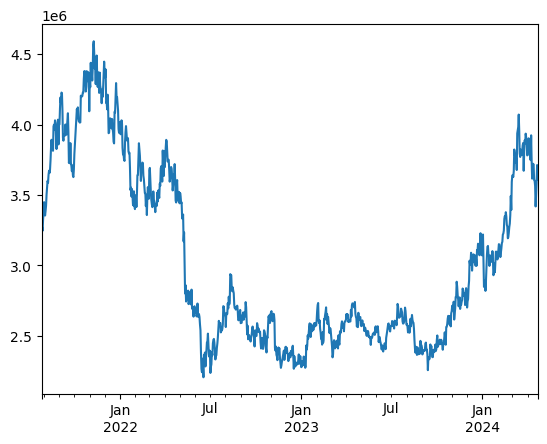

In [ ]:
indser.plot()

In [1]:
weightdf[weightdf["Date"]=='2024-01-01']

NameError: name 'weightdf' is not defined

In [ ]:
btcw = weightdf[weightdf["Currency"] == "BTC"]
btcw.set_index("Date", inplace=True)

<Axes: xlabel='Date'>

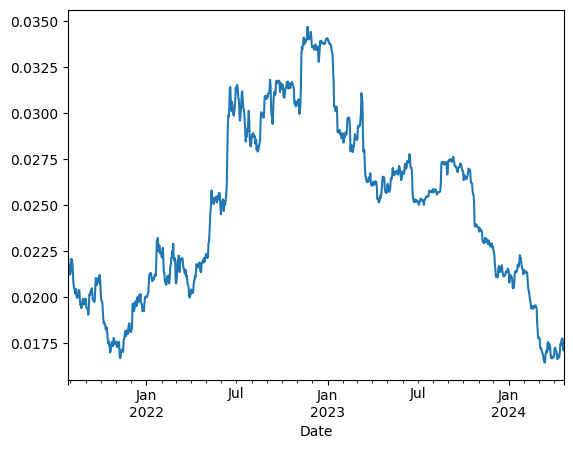

In [ ]:
btcw.Weight.plot()

In [ ]:
indser.describe()

count    1.000000e+03
mean     3.028619e+06
std      6.332515e+05
min      2.206022e+06
25%      2.518572e+06
50%      2.704225e+06
75%      3.611119e+06
max      4.592469e+06
Name: Index, dtype: float64

In [ ]:
indser.pct_change().describe()

count    999.000000
mean       0.000318
std        0.020535
min       -0.075931
25%       -0.012413
50%        0.000143
75%        0.013088
max        0.072319
Name: Index, dtype: float64

In [ ]:
df[df.Currency == "BTC"].Price.pct_change().describe()

count    999.000000
mean       0.000830
std        0.024223
min       -0.122941
25%       -0.010526
50%        0.000786
75%        0.010195
max        0.114638
Name: Price, dtype: float64